## 사용할 라이브러리 버전 둘러보기

In [1]:
import pandas
import konlpy
import gensim

print(pandas.__version__)
print(konlpy.__version__)
print(gensim.__version__)

1.3.3
0.5.2
4.1.2


## 데이터 준비와 확인

In [2]:
import pandas as pd

# 데이터를 읽어봅시다. 
train_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


## 데이터로더 구성

- 데이터의 중복 제거
- NaN 결측치 제거
- 한국어 토크나이저로 토큰화
- 불용어(Stopwords) 제거
- 사전word_to_index 구성
- 텍스트 스트링을 사전 인덱스 스트링으로 변환
- X_train, y_train, X_test, y_test, word_to_index 리턴

In [8]:
from konlpy.tag import Mecab
import numpy as np
from collections import Counter

tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=10000):
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how = 'any') 
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any') 
    
    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)
    
    words = np.concatenate(X_train).tolist()
    counter = Counter(words) # 전체 학습 데이터에서 나온 단어들의 등장 횟수 세기
    counter = counter.most_common(num_words-4) # 특수 토큰을 위해 num_words에서 4를 뺀 값만큼만 사용할 문자로 지정
    vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}
        
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]
        
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
        
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index
    
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data) 

In [9]:
index_to_word = {index:word for word, index in word_to_index.items()}

## 문장 인코더와 디코더

In [10]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

## 모델 구성을 위한 데이터 분석 및 가공

### 데이터셋 내 문장 길이 분포, 최대 문장 길이 지정

In [12]:
total_data_text = list(X_train) + list(X_test)
# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)
# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다. 
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

# 예를들어, 최대 길이를 (평균 + 2*표준편차)로 한다면,  
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print(f'전체 문장의 {np.sum(num_tokens < max_tokens) / len(num_tokens)}%가 maxlen 설정값 이내에 포함됩니다. ')

문장길이 평균 :  15.96940191154864
문장길이 최대 :  116
문장길이 표준편차 :  12.843571191092
pad_sequences maxlen :  41
전체 문장의 0.9342988343341575%가 maxlen 설정값 이내에 포함됩니다. 


### 패딩 추가

In [14]:
import tensorflow as tf

X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='pre',
                                                        maxlen=maxlen)

X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='pre',
                                                       maxlen=maxlen)

print(X_train.shape)

(146182, 41)


## 모델 구성 및 validation set 구성

### 모델 1. LSTM

In [15]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 16  # 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터)

# model 설계 - 딥러닝 모델 코드를 직접 작성해 주세요.
model_1 = tf.keras.Sequential()
model_1.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_1.add(tf.keras.layers.LSTM(32, recurrent_dropout=0.25))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 32로 하였습니다. (변경 가능)
model_1.add(tf.keras.layers.Dropout(0.5))
model_1.add(tf.keras.layers.Dense(32, activation='relu'))
model_1.add(tf.keras.layers.Dropout(0.5))
model_1.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model_1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          160000    
_________________________________________________________________
lstm (LSTM)                  (None, 32)                6272      
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 32)                1056      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 167,361
Trainable params: 167,361
Non-trainable params: 0
__________________________________________________

### 모델 2. Double GRU

In [16]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 16  # 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터)

# model 설계 - 딥러닝 모델 코드를 직접 작성해 주세요.
model_2 = tf.keras.Sequential()
model_2.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_2.add(tf.keras.layers.GRU(32, recurrent_dropout=0.5, return_sequences=True))   # GRU layer 2개로 변경
model_2.add(tf.keras.layers.GRU(32, recurrent_dropout=0.5))
model_2.add(tf.keras.layers.Dropout(0.5))
model_2.add(tf.keras.layers.Dense(32, activation='relu'))
model_2.add(tf.keras.layers.Dropout(0.5))
model_2.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model_2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
gru (GRU)                    (None, None, 32)          4800      
_________________________________________________________________
gru_1 (GRU)                  (None, 32)                6336      
_________________________________________________________________
dropout_2 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 32)                1056      
_________________________________________________________________
dropout_3 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                

### 모델 3. Transformer

In [17]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 16  # 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터)

# model 설계 - 딥러닝 모델 코드를 직접 작성해 주세요.
inputs = tf.keras.Input(shape=(None,), dtype="int32")

# 1. 임베딩 레이어
embedding_layer = tf.keras.layers.Embedding(vocab_size, word_vector_dim)(inputs)

# 2. 위치 인코딩 추가 (간단한 학습형)
pos_encoding = tf.keras.layers.Embedding(input_dim=maxlen, output_dim=word_vector_dim)(
    tf.range(start=0, limit=maxlen, delta=1)
)
embedded_with_pos = embedding_layer + pos_encoding[:tf.shape(embedding_layer)[1]]

# 3. Transformer block
attention_output = tf.keras.layers.MultiHeadAttention(
    num_heads=2, key_dim=word_vector_dim
)(embedded_with_pos, embedded_with_pos)
attention_output = tf.keras.layers.Dropout(0.5)(attention_output)
attention_output = tf.keras.layers.LayerNormalization(epsilon=1e-6)(attention_output + embedded_with_pos)

# 4. Feed Forward Network
fwd = tf.keras.layers.Dense(64, activation="relu")(attention_output)
fwd = tf.keras.layers.Dense(word_vector_dim)(fwd)
fwd = tf.keras.layers.Dropout(0.5)(fwd)
fwd = tf.keras.layers.LayerNormalization(epsilon=1e-6)(fwd + attention_output)

# 5. Global Average Pooling + Classifier
pooled = tf.keras.layers.GlobalAveragePooling1D()(fwd)
pooled = tf.keras.layers.Dense(32, activation="relu")(pooled)
pooled = tf.keras.layers.Dropout(0.5)(pooled)
outputs = tf.keras.layers.Dense(1, activation="sigmoid")(pooled)

model_3 = tf.keras.Model(inputs=inputs, outputs=outputs)

model_3.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, None, 16)     160000      input_1[0][0]                    
__________________________________________________________________________________________________
tf.compat.v1.shape (TFOpLambda) (3,)                 0           embedding_2[0][0]                
__________________________________________________________________________________________________
tf.__operators__.getitem (Slici ()                   0           tf.compat.v1.shape[0][0]         
______________________________________________________________________________________________

### Validation set 분리

In [18]:
print(X_train.shape)
print(X_test.shape)

(146182, 41)
(49157, 41)


In [20]:
# validation set 49157건 분리 (test set과 크기 동일)
X_val = X_train[:49157]   
y_val = y_train[:49157]

# validation set을 제외한 나머지
partial_X_train = X_train[49157:]  
partial_y_train = y_train[49157:]

print(partial_X_train.shape)
print(partial_y_train.shape)

(97025, 41)
(97025,)


## 모델 훈련 개시

### 1번 모델 훈련 (LSTM)

In [22]:
model_1.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=10

history = model_1.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/10
190/190 [==============================] - 28s 132ms/step - loss: 0.5094 - accuracy: 0.7542 - val_loss: 0.3664 - val_accuracy: 0.8402
Epoch 2/10
190/190 [==============================] - 25s 134ms/step - loss: 0.3598 - accuracy: 0.8533 - val_loss: 0.3486 - val_accuracy: 0.8497
Epoch 3/10
190/190 [==============================] - 26s 135ms/step - loss: 0.3371 - accuracy: 0.8650 - val_loss: 0.3508 - val_accuracy: 0.8473
Epoch 4/10
190/190 [==============================] - 25s 134ms/step - loss: 0.3208 - accuracy: 0.8729 - val_loss: 0.3516 - val_accuracy: 0.8475
Epoch 5/10
190/190 [==============================] - 26s 136ms/step - loss: 0.3088 - accuracy: 0.8767 - val_loss: 0.3572 - val_accuracy: 0.8471
Epoch 6/10
190/190 [==============================] - 26s 135ms/step - loss: 0.2986 - accuracy: 0.8805 - val_loss: 0.3622 - val_accuracy: 0.8467
Epoch 7/10
190/190 [==============================] - 26s 135ms/step - loss: 0.2847 - accuracy: 0.8854 - val_loss: 0.3670 - val_ac

### 2번 모델 훈련 (Double GRU)

In [23]:
model_2.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=10

history_GRU = model_2.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/10
190/190 [==============================] - 50s 246ms/step - loss: 0.5040 - accuracy: 0.7530 - val_loss: 0.3620 - val_accuracy: 0.8433
Epoch 2/10
190/190 [==============================] - 46s 242ms/step - loss: 0.3678 - accuracy: 0.8506 - val_loss: 0.3503 - val_accuracy: 0.8500
Epoch 3/10
190/190 [==============================] - 46s 244ms/step - loss: 0.3420 - accuracy: 0.8638 - val_loss: 0.3527 - val_accuracy: 0.8476
Epoch 4/10
190/190 [==============================] - 46s 245ms/step - loss: 0.3254 - accuracy: 0.8721 - val_loss: 0.3552 - val_accuracy: 0.8467
Epoch 5/10
190/190 [==============================] - 46s 244ms/step - loss: 0.3127 - accuracy: 0.8773 - val_loss: 0.3598 - val_accuracy: 0.8480
Epoch 6/10
190/190 [==============================] - 46s 242ms/step - loss: 0.3010 - accuracy: 0.8827 - val_loss: 0.3658 - val_accuracy: 0.8446
Epoch 7/10
190/190 [==============================] - 46s 242ms/step - loss: 0.2907 - accuracy: 0.8882 - val_loss: 0.3695 - val_ac

### 3번 모델 훈련 (Transformer)

In [24]:
model_3.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=10

history_TRS = model_3.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/10
190/190 [==============================] - 3s 10ms/step - loss: 0.5066 - accuracy: 0.7441 - val_loss: 0.3620 - val_accuracy: 0.8429
Epoch 2/10
190/190 [==============================] - 2s 8ms/step - loss: 0.3580 - accuracy: 0.8521 - val_loss: 0.3527 - val_accuracy: 0.8466
Epoch 3/10
190/190 [==============================] - 2s 8ms/step - loss: 0.3379 - accuracy: 0.8614 - val_loss: 0.3573 - val_accuracy: 0.8458
Epoch 4/10
190/190 [==============================] - 2s 8ms/step - loss: 0.3245 - accuracy: 0.8665 - val_loss: 0.3641 - val_accuracy: 0.8438
Epoch 5/10
190/190 [==============================] - 2s 8ms/step - loss: 0.3164 - accuracy: 0.8693 - val_loss: 0.3688 - val_accuracy: 0.8448
Epoch 6/10
190/190 [==============================] - 2s 8ms/step - loss: 0.3090 - accuracy: 0.8719 - val_loss: 0.3760 - val_accuracy: 0.8441
Epoch 7/10
190/190 [==============================] - 2s 8ms/step - loss: 0.3010 - accuracy: 0.8725 - val_loss: 0.3735 - val_accuracy: 0.8404
Epoch

## Loss, Accuracy 그래프 시각화

### LSTM

In [25]:
history_dict = history.history
print(history_dict.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


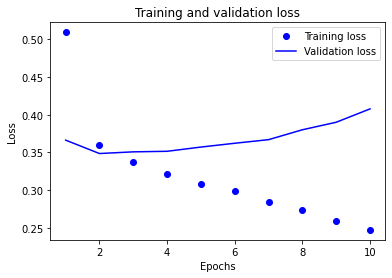

In [26]:
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

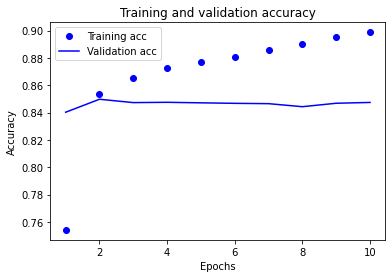

In [27]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

### Double GRU

In [28]:
history_dict = history_GRU.history
print(history_dict.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


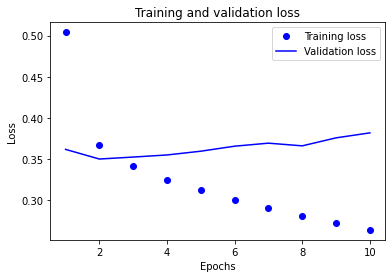

In [29]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

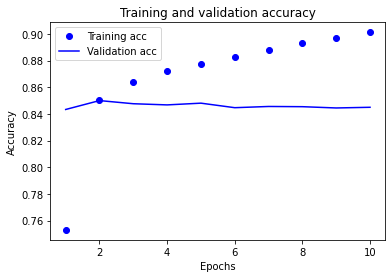

In [30]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

### Transformer

In [31]:
history_dict = history_TRS.history
print(history_dict.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


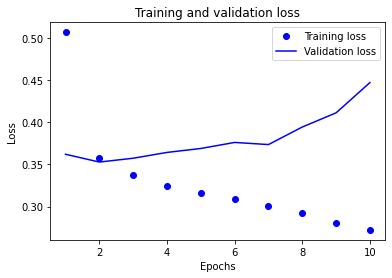

In [32]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

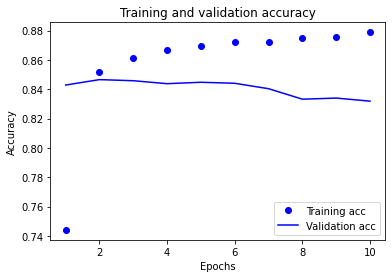

In [33]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

## 학습된 Embedding layer 분석

### T-SNE를 이용한 Embedding layer 시각화 함수

In [38]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import matplotlib as mpl

# 한글 폰트 설정 (NanumGothic 사용 가능해야 함)
plt.rc('font', family='NanumGothic')
mpl.rcParams['axes.unicode_minus'] = False

def visualize_embedding_tsne(model, word_to_index, layer_index=0, num_words=100):
    """
    모델의 임베딩 레이어를 t-SNE로 시각화하는 함수

    Args:
        model: 학습된 Keras 모델
        word_to_index: 단어 -> 정수 인덱스 딕셔너리
        layer_index: 임베딩 레이어의 인덱스 (기본값 0)
        num_words: 시각화할 단어 수 (기본값 100)

    Returns:
        None (matplotlib 시각화 실행)
    """
    # 특수 토큰 4개 제외하고 가장 많이 쓰인 단어 순서대로 정렬
    vocab_items = list(word_to_index.items())
    vocab_items = sorted(vocab_items, key=lambda x: x[1])  # index 순으로 정렬
    words = [word for word, idx in vocab_items[4:4+num_words]]
    indices = [idx for word, idx in vocab_items[4:4+num_words]]

    # 임베딩 가중치 추출
    embedding_layer = model.layers[layer_index]
    embedding_weights = embedding_layer.get_weights()[0]  # (vocab_size, embedding_dim)
    vectors = embedding_weights[indices]

    # t-SNE 차원 축소
    tsne = TSNE(n_components=2, random_state=42, perplexity=30)
    reduced = tsne.fit_transform(vectors)

    # 시각화
    plt.figure(figsize=(12, 12))
    for i, word in enumerate(words):
        plt.scatter(reduced[i, 0], reduced[i, 1])
        plt.annotate(word, (reduced[i, 0], reduced[i, 1]))
    plt.title("t-SNE로 시각화한 임베딩 벡터")
    plt.grid(True)
    plt.show()

### LSTM T-SNE 분석

/opt/conda/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


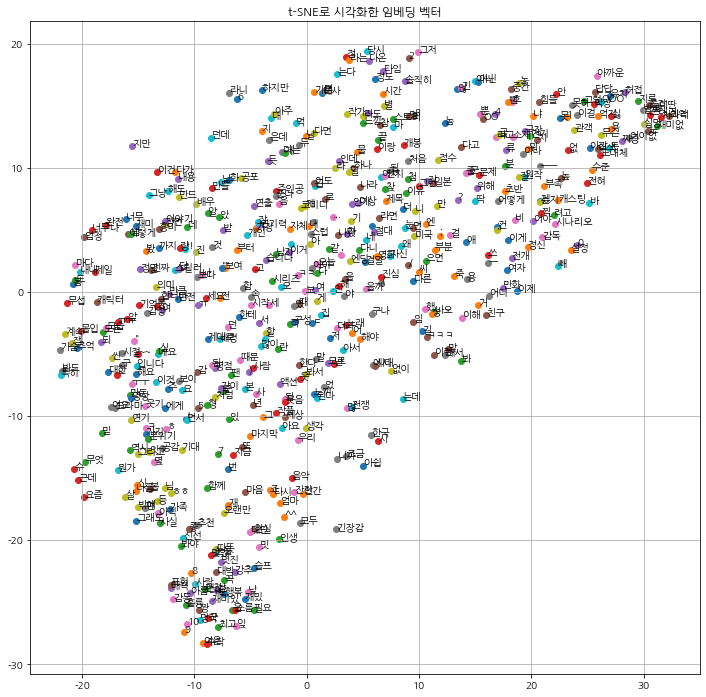

In [41]:
visualize_embedding_tsne(model_1, word_to_index, layer_index=0, num_words=500)

- 그래프의 하단 부분에는 긍정적 단어가, 상단 부분에는 부정적 단어가 서로 뭉쳐있다.
- 긍정과 부정에 따라 좌측 하단과 우측 상단으로 비교적 잘 나누어진 것으로 보인다.
- 우측 하단 부분에 근데, 요즘, 무엇, 뭔가 등은 긍정이나 부정으로 구분하기 어려워 그래프 중앙에 위치해야 할 것 같은데 긍정적 반응과 가까운 거리인 것이 특이했다.

### LSTM gensim 분석

In [46]:
import os

# 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 
word2vec_file_path = os.getenv('HOME')+'/aiffel/AIFFEL_quest_rs/Exploration/Ex05/word2vec_LSTM.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors = model_1.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [47]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['재밌']
vector

array([-0.14492385,  0.14758816,  0.125197  , -0.12804751, -0.18425794,
       -0.13422534,  0.11299456,  0.11779617, -0.12062769,  0.13380094,
       -0.1427759 , -0.15584517, -0.0038101 ,  0.0736338 , -0.11605669,
       -0.1051313 ], dtype=float32)

#### 긍정적 단어

In [48]:
word_vectors.similar_by_word("추천")

[('on', 0.9285926818847656),
 ('값진', 0.921441376209259),
 ('김새론', 0.9153819680213928),
 ('해집니다', 0.9138036966323853),
 ('새록새록', 0.9136953949928284),
 ('역작', 0.9121912717819214),
 ('잼따', 0.90936678647995),
 ('해내', 0.9078079462051392),
 ('맞서', 0.9063632488250732),
 ('아담', 0.9062688946723938)]

In [49]:
word_vectors.similar_by_word("강추")

[('작년', 0.961296796798706),
 ('아날로그', 0.9557070136070251),
 ('지나쳤', 0.9528599381446838),
 ('옳', 0.9523501992225647),
 ('현기증', 0.9520189762115479),
 ('명불허전', 0.9504356980323792),
 ('바스코', 0.9434463977813721),
 ('장난아', 0.9427112936973572),
 ('쿵', 0.9423104524612427),
 ('연정훈', 0.9422510266304016)]

#### 부정적 단어

In [50]:
word_vectors.similar_by_word("재미없")

[('실망', 0.9818296432495117),
 ('놨', 0.9800967574119568),
 ('찝찝', 0.9798664450645447),
 ('강간', 0.9791831970214844),
 ('본데', 0.9771460890769958),
 ('에휴', 0.9744740128517151),
 ('떨어집니다', 0.972170889377594),
 ('돈', 0.9713448286056519),
 ('개막', 0.970039963722229),
 ('레기', 0.9697529673576355)]

In [51]:
word_vectors.similar_by_word("최악")

[('그럴듯', 0.9863772988319397),
 ('이따위', 0.9852993488311768),
 ('발표', 0.9838858246803284),
 ('별론데', 0.982643187046051),
 ('지겨웠', 0.9825503826141357),
 ('외전', 0.9821779727935791),
 ('개뿔', 0.9808640480041504),
 ('차라리', 0.9801918268203735),
 ('아까', 0.980094313621521),
 ('김인권', 0.979469895362854)]

#### 중립적 단어

In [52]:
word_vectors.similar_by_word("연출")

[('뉘', 0.8283952474594116),
 ('에이미', 0.8192673325538635),
 ('안겨', 0.8052122592926025),
 ('케릭', 0.7844768166542053),
 ('약한', 0.7706108093261719),
 ('김수로', 0.7593753933906555),
 ('여장', 0.7533441185951233),
 ('그림', 0.7466869950294495),
 ('알아들', 0.741496205329895),
 ('블러드', 0.7404201030731201)]

In [53]:
word_vectors.similar_by_word("주인공")

[('내전', 0.8661400079727173),
 ('게리올드만', 0.8615758419036865),
 ('과욕', 0.8608019351959229),
 ('지미', 0.845523476600647),
 ('준다', 0.8299497961997986),
 ('재치', 0.819083034992218),
 ('이다해', 0.815287172794342),
 ('다던', 0.8151418566703796),
 ('으므로', 0.8149560689926147),
 ('떨림', 0.8112761974334717)]

- 긍정적 단어와 부정적 단어를 비교해 보니 확실히 비슷한 느낌의 단어가 가까이 위치하는 것을 확인할 수 있다.
- 중립적 단어를 확인했을 땐 서로의 연관성이 꽤 떨어져 보인다.

### Double GRU T-SNE 분석

/opt/conda/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


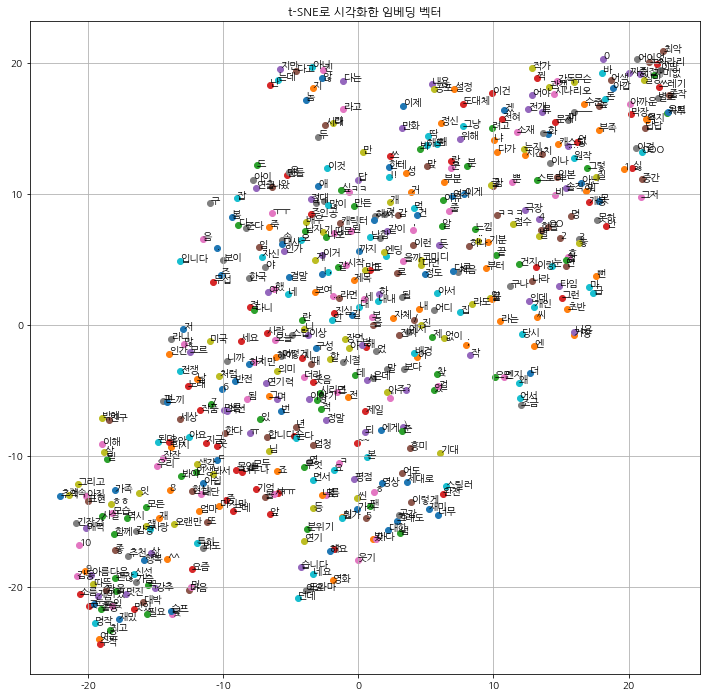

In [42]:
visualize_embedding_tsne(model_2, word_to_index, layer_index=0, num_words=500)

- 그래프의 하단 부분에는 긍정적 단어가, 상단 부분에는 부정적 단어가 서로 뭉쳐있다.
- 긍정과 부정에 따라 좌측 하단과 우측 상단으로 비교적 잘 나누어진 것으로 보인다.
- 아쉽, 이해 등 LSTM에서는 비교적 부정적으로 분류되었던 단어들이 좌측 하단에 가깝게 위치하는 것이 특이하다.

### Double GRU gensim 분석

In [54]:
# 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 
word2vec_file_path = os.getenv('HOME')+'/aiffel/AIFFEL_quest_rs/Exploration/Ex05/word2vec_DGRU.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors = model_2.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [55]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['재밌']
vector

array([-0.04897138,  0.10459607,  0.07279194, -0.03684366,  0.12485462,
        0.11258637,  0.08916093, -0.11450619,  0.134132  ,  0.13525496,
        0.08434437, -0.13643226, -0.12942304,  0.16642165,  0.13379939,
        0.02442325], dtype=float32)

#### 긍정적 단어

In [56]:
word_vectors.similar_by_word("추천")

[('치가', 0.9610046148300171),
 ('금고', 0.9271741509437561),
 ('여사', 0.9259651899337769),
 ('소름', 0.9219239354133606),
 ('장수', 0.9204745292663574),
 ('박혀', 0.9163613319396973),
 ('밀리', 0.9150910973548889),
 ('닌', 0.9145947098731995),
 ('푹', 0.9138303995132446),
 ('^.^', 0.9124380350112915)]

In [57]:
word_vectors.similar_by_word("강추")

[('프리퀄', 0.9465558528900146),
 ('반대편', 0.9456825852394104),
 ('노예', 0.9378964304924011),
 ('김새론', 0.9367483258247375),
 ('해집니다', 0.9349711537361145),
 ('미생', 0.9317389130592346),
 ('우산', 0.9296053647994995),
 ('성동일', 0.9266393184661865),
 ('통틀어', 0.9256103038787842),
 ('정윤희', 0.9243903756141663)]

#### 부정적 단어

In [58]:
word_vectors.similar_by_word("재미없")

[('방지', 0.9781821370124817),
 ('엎', 0.9768099784851074),
 ('없음', 0.9766775369644165),
 ('떨어짐', 0.9766635894775391),
 ('겉돌', 0.9766058921813965),
 ('하품', 0.975992739200592),
 ('꽝', 0.9753913283348083),
 ('with', 0.9748398661613464),
 ('단다', 0.9745923280715942),
 ('어설퍼', 0.974565863609314)]

In [59]:
word_vectors.similar_by_word("최악")

[('인내심', 0.9875154495239258),
 ('개그맨', 0.985419511795044),
 ('공짜', 0.9827715158462524),
 ('낭비', 0.9823983311653137),
 ('건질', 0.9815084934234619),
 ('선조', 0.9815052151679993),
 ('타이밍', 0.9813363552093506),
 ('퇴화', 0.9805098176002502),
 ('역겨웠', 0.980270504951477),
 ('성괴', 0.9799580574035645)]

#### 중립적 단어

In [60]:
word_vectors.similar_by_word("연출")

[('끼치', 0.8732634782791138),
 ('아이', 0.857036828994751),
 ('창작', 0.7258376479148865),
 ('반데라스', 0.7192230224609375),
 ('깨우치', 0.7148554921150208),
 ('캐서린', 0.7047703266143799),
 ('조셉', 0.6975411176681519),
 ('빚', 0.6908149719238281),
 ('꼇다', 0.6447331309318542),
 ('소지', 0.6442989706993103)]

In [61]:
word_vectors.similar_by_word("주인공")

[('캡', 0.7722141146659851),
 ('호평', 0.7417604923248291),
 ('공포', 0.7107060551643372),
 ('(', 0.7054150104522705),
 ('크', 0.6784420013427734),
 ('나타나', 0.6782654523849487),
 ('자본', 0.6598983407020569),
 ('배우', 0.6497935652732849),
 ('메시지', 0.6470217108726501),
 ('발음', 0.6441758275032043)]

- LSTM에 비해 긍정적 단어의 유사 단어가 비슷한 의미를 가지지 않는 경향을 보인다.
- 부정적 단어는 LSTM과 마찬가지로 유사 단어가 모두 부정적인 경향을 보인다.
- 중립적 단어는 LSTM에 비해 의미적으로 유사한 단어가 조금 증가한 느낌을 받았다.

### Transformer T-SNE 분석

/opt/conda/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


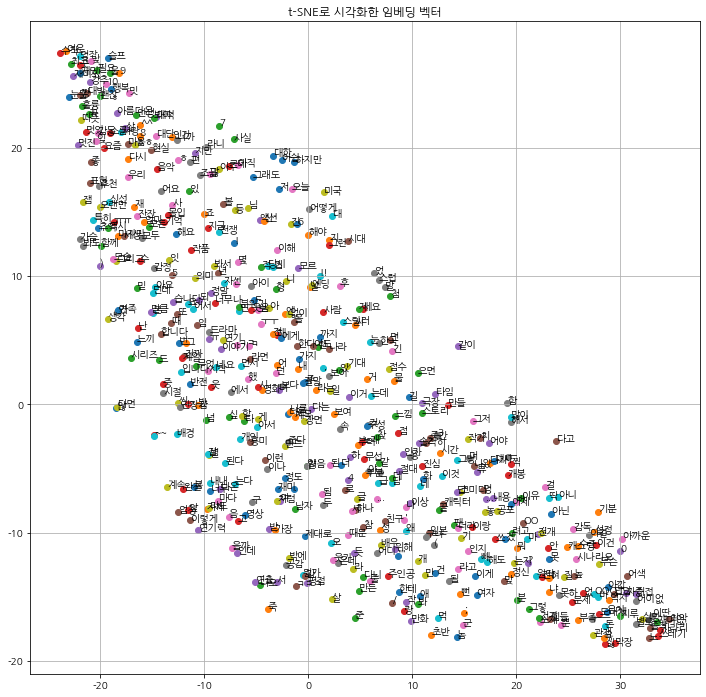

In [43]:
visualize_embedding_tsne(model_3, word_to_index, layer_index=1, num_words=500)

- 그래프의 하단 부분에는 부정적 단어가, 상단 부분에는 긍정적 단어가 서로 뭉쳐있다.
- 긍정과 부정에 따라 좌측 상단과 우측 하단으로 비교적 잘 나누어진 것으로 보인다.

### Transformer gensim 분석

In [63]:
# 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 
word2vec_file_path = os.getenv('HOME')+'/aiffel/AIFFEL_quest_rs/Exploration/Ex05/word2vec_TRS.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors = model_3.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [64]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['재밌']
vector

array([-0.18392204, -0.0970301 , -0.14498548, -0.12671126,  0.17342356,
       -0.0869613 , -0.17499913,  0.11042929, -0.12082957,  0.16023889,
        0.04131757,  0.09786255, -0.1446237 ,  0.16629179,  0.14543435,
       -0.03831667], dtype=float32)

#### 긍정적 단어

In [65]:
word_vectors.similar_by_word("추천")

[('해적', 0.9468876123428345),
 ('서부터', 0.940825343132019),
 ('오랫동안', 0.9384385943412781),
 ('훌륭', 0.9361120462417603),
 ('오랜만', 0.9342657327651978),
 ('설레', 0.933970034122467),
 ('눈시울', 0.9325745105743408),
 ('신은경', 0.9316900968551636),
 ('이런지', 0.9293494820594788),
 ('아카데미', 0.9282832145690918)]

In [66]:
word_vectors.similar_by_word("강추")

[('굿', 0.975807249546051),
 ('봐야지', 0.9720256924629211),
 ('짠', 0.9680871367454529),
 ('빠져', 0.9672785401344299),
 ('엄연히', 0.9665430784225464),
 ('재밌', 0.9662942290306091),
 ('명품', 0.9618401527404785),
 ('울린', 0.9605937600135803),
 ('대박', 0.9603214263916016),
 ('애잔', 0.9600906372070312)]

#### 부정적 단어

In [67]:
word_vectors.similar_by_word("재미없")

[('.,,', 0.9856051206588745),
 ('오리엔탈리즘', 0.9791647791862488),
 ('이딴', 0.9780352115631104),
 ('밀어주', 0.9770883321762085),
 ('그래요', 0.9770458936691284),
 ('차라리', 0.9761936068534851),
 ('과유불급', 0.9755762815475464),
 ('오점', 0.9753406643867493),
 ('탁재훈', 0.9745622277259827),
 ('마감', 0.9742950797080994)]

In [68]:
word_vectors.similar_by_word("최악")

[('개뿔', 0.9935146570205688),
 ('꺼지', 0.9883585572242737),
 ('이질감', 0.9867199659347534),
 ('사기', 0.9864634871482849),
 ('전범', 0.9860745072364807),
 ('뇬', 0.9855384826660156),
 ('구림', 0.9853010177612305),
 ('서세원', 0.985091507434845),
 ('모욕', 0.9850401282310486),
 ('그라', 0.9847396016120911)]

#### 중립적 단어

In [69]:
word_vectors.similar_by_word("연출")

[('나오', 0.6836780309677124),
 ('였으나', 0.6298444867134094),
 ('보네', 0.6275606155395508),
 ('외계인', 0.6021583676338196),
 ('time', 0.5947486758232117),
 ('인데', 0.5873705148696899),
 ('메시지', 0.5824764966964722),
 ('전개', 0.5820288062095642),
 ('별다른', 0.5816731452941895),
 ('생길', 0.575908362865448)]

In [70]:
word_vectors.similar_by_word("주인공")

[('얼굴', 0.6624359488487244),
 ('깨우치', 0.6569719314575195),
 ('얘기', 0.6569580435752869),
 ('이스라엘', 0.6543636918067932),
 ('소설', 0.6470383405685425),
 ('버려', 0.6300697326660156),
 ('내놓', 0.6281275153160095),
 ('유일', 0.6266981959342957),
 ('어야지', 0.6137288212776184),
 ('먹히', 0.6115208268165588)]

- 위 두 모델과 비교해서 큰 차이점을 찾지 못했다.

## 한국어 Word2Vec 임베딩 활용

### word2vec_ko.model 불러오기

In [76]:
from gensim.models.keyedvectors import Word2VecKeyedVectors
word2vec_file_path = os.getenv('HOME')+'/data/word2vec_ko.model'
word_vectors = Word2VecKeyedVectors.load(word2vec_file_path)
vector = word_vectors.wv['끝']

In [91]:
word_vectors.wv.similar_by_word("추천")

[('천거', 0.7103838920593262),
 ('초빙', 0.687961220741272),
 ('초청', 0.6826260089874268),
 ('위촉', 0.6571412682533264),
 ('포상', 0.6499664783477783),
 ('선출', 0.6489635705947876),
 ('소개', 0.6427397727966309),
 ('임명', 0.6394351124763489),
 ('등용', 0.6328903436660767),
 ('추대', 0.6315879225730896)]

위 모델의 임베딩에 비해 실제 단어의 유사도를 중심으로 단어 사이의 거리가 결정되는 듯 보인다.

### Word2Vec 임베딩을 활용한 LSTM 모델 만들기

In [80]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 100  # 워드 벡터의 차원수
embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드 벡터를 단어 하나씩마다 차례차례 카피한다.
for i in range(4,vocab_size):
    if index_to_word[i] in word_vectors.wv:
        embedding_matrix[i] = word_vectors.wv[index_to_word[i]]

In [82]:
from tensorflow.keras.initializers import Constant

vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 100  # 워드 벡터의 차원 수 

# 모델 구성
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
model.add(tf.keras.layers.LSTM(64, recurrent_dropout=0.5))  # 시퀀스를 압축
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(32, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 41, 100)           1000000   
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                42240     
_________________________________________________________________
dropout_7 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 33        
Total params: 1,044,353
Trainable params: 1,044,353
Non-trainable params: 0
_________________________________________________________________


### 모델 학습

In [85]:
# 학습의 진행
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=10  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/10
190/190 [==============================] - 30s 150ms/step - loss: 0.5581 - accuracy: 0.7053 - val_loss: 0.4462 - val_accuracy: 0.7946
Epoch 2/10
190/190 [==============================] - 29s 150ms/step - loss: 0.4301 - accuracy: 0.8054 - val_loss: 0.3820 - val_accuracy: 0.8296
Epoch 3/10
190/190 [==============================] - 28s 150ms/step - loss: 0.3758 - accuracy: 0.8346 - val_loss: 0.3532 - val_accuracy: 0.8442
Epoch 4/10
190/190 [==============================] - 29s 150ms/step - loss: 0.3444 - accuracy: 0.8505 - val_loss: 0.3481 - val_accuracy: 0.8473
Epoch 5/10
190/190 [==============================] - 29s 152ms/step - loss: 0.3206 - accuracy: 0.8630 - val_loss: 0.3373 - val_accuracy: 0.8534
Epoch 6/10
190/190 [==============================] - 28s 150ms/step - loss: 0.3046 - accuracy: 0.8711 - val_loss: 0.3286 - val_accuracy: 0.8584
Epoch 7/10
190/190 [==============================] - 29s 151ms/step - loss: 0.2905 - accuracy: 0.8774 - val_loss: 0.3254 - val_ac

### 학습한 모델 결과 시각화

In [86]:
history_dict = history.history
print(history_dict.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


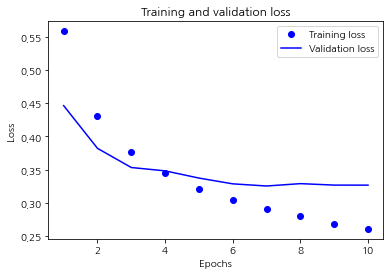

In [87]:
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

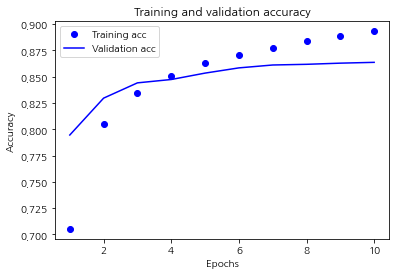

In [88]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

- 이전 모델들에 비해 오버피팅 현상이 확연히 줄어든 모습을 확인할 수 있다.

### test set 성능 확인

In [90]:
# 테스트셋을 통한 모델 평가
results = model.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 18s - loss: 0.3359 - accuracy: 0.8593
[0.3358602523803711, 0.8592875599861145]


### 파인튜닝된 Embedding layer 분석

In [93]:
# 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 
word2vec_file_path = os.getenv('HOME')+'/aiffel/AIFFEL_quest_rs/Exploration/Ex05/word2vec_finetuned.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors = model.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [94]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['재밌']
vector

array([ 6.3428205e-01, -9.3740964e-01, -1.1969746e+00,  1.4138583e+00,
        1.0329694e+00,  6.6271469e-02,  6.8614870e-02, -1.2269771e+00,
       -1.4095829e+00, -4.5909247e-01,  9.6207100e-01,  1.6651388e+00,
        3.1075874e-01,  1.9471093e-01,  1.3583823e+00,  5.0124604e-01,
        1.6608906e-01, -1.1423767e-01,  6.1684304e-01, -8.7826490e-01,
       -7.4402553e-01,  1.7142028e+00,  1.4985701e+00, -2.5402263e-01,
        3.0844483e-01,  3.0204663e-01, -6.9649249e-01,  6.8079966e-01,
        1.8744557e+00,  6.1799848e-01, -1.8367809e+00, -7.4395472e-01,
       -4.1729769e-01, -1.0345066e+00,  5.4308993e-01,  2.6740649e-01,
       -1.7896205e+00,  9.4696683e-01,  3.1236264e-01,  9.8290175e-01,
       -4.6140504e-01,  6.6168851e-01,  2.9737762e-01,  7.5364542e-01,
       -2.2401035e+00, -1.1631852e+00, -1.3149724e+00, -1.7874752e+00,
        1.6996324e+00,  2.7448502e-01, -9.8159677e-01,  3.7750736e-01,
        8.2367891e-01, -4.9364135e-01, -6.3756543e-01, -1.0683415e+00,
      

In [95]:
word_vectors.similar_by_word("추천")

[('소개', 0.6416309475898743),
 ('선정', 0.6256622076034546),
 ('초대', 0.6082555651664734),
 ('부탁', 0.6030844449996948),
 ('선택', 0.5797954201698303),
 ('설득', 0.5685180425643921),
 ('평가', 0.5684208273887634),
 ('심사', 0.5684162974357605),
 ('요청', 0.5596274137496948),
 ('칭찬', 0.5445115566253662)]

In [98]:
word_vectors.similar_by_word("강추")

[('^^♥', 0.8380762934684753),
 ('괜춘', 0.8364500403404236),
 ('...?', 0.8353416919708252),
 ('애뜻', 0.8345005512237549),
 ('톰크루즈', 0.833732008934021),
 ('찔끔', 0.8314511179924011),
 ('밋기', 0.8279290795326233),
 ('♥♥♥', 0.8228998184204102),
 ('♥♥', 0.8225681781768799),
 ('예뻐요', 0.8215431571006775)]

In [99]:
word_vectors.similar_by_word("재미없")

[('드럽', 0.837227463722229),
 ('어처구니없', 0.8203529715538025),
 ('화났', 0.8137203454971313),
 ('맛없', 0.803516149520874),
 ('어설프', 0.793060839176178),
 ('속상하', 0.7908697724342346),
 ('아까웠', 0.7905759215354919),
 ('이딴', 0.7860036492347717),
 ('허접', 0.7802826762199402),
 ('오글거리', 0.7797650694847107)]

In [100]:
word_vectors.similar_by_word("최악")

[('희대', 0.5970731377601624),
 ('최고', 0.5464892387390137),
 ('최저', 0.5356552004814148),
 ('뜻밖', 0.5351651310920715),
 ('엄청난', 0.4964437782764435),
 ('역대', 0.4896719753742218),
 ('흥행', 0.47983795404434204),
 ('오점', 0.4796522557735443),
 ('최강', 0.47963082790374756),
 ('부진', 0.4778069257736206)]

In [101]:
word_vectors.similar_by_word("연출")

[('연기', 0.7612345814704895),
 ('각색', 0.7350841164588928),
 ('각본', 0.6646267175674438),
 ('패러디', 0.6500810980796814),
 ('출연', 0.6473439931869507),
 ('열연', 0.6429790258407593),
 ('극본', 0.6397433876991272),
 ('재연', 0.6379663348197937),
 ('촬영', 0.6361806988716125),
 ('감상', 0.6340648531913757)]

In [102]:
word_vectors.similar_by_word("주인공")

[('여주인공', 0.8557924032211304),
 ('악당', 0.7636579871177673),
 ('악역', 0.7364579439163208),
 ('원작', 0.7318591475486755),
 ('등장인물', 0.7151608467102051),
 ('캐릭터', 0.6758906841278076),
 ('여고생', 0.6588796377182007),
 ('악녀', 0.6529126763343811),
 ('닌자', 0.6367143988609314),
 ('뱀파이어', 0.6353899836540222)]

- 이전 모델들에 비해 실제 의미가 유사한 단어들이 많이 확인된다.